In [31]:
# In this notebook we will show how to use the Fourier inference to infer the heat kernel from a set of time-localized samples.
import numpy as np
from fourier import compute_fourier_coeff, get_fourier_coeffs
from target_signals import  compute_heat_kernel
from generate_input_signals import generate_time_localized_samples
from fourier_inference import  compute_prediction

import matplotlib.pyplot as plt

In [32]:
seed = 42  # or any integer of choice
rng = np.random.default_rng(seed)

In [33]:
# Number of input functions
num_samples = 15

grid_size = 2**11 # grid points

t_left = -30
t_right = 30   # time interval

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)
noise = .001 # noise level in the data
freqs = np.fft.fftfreq(grid_size, time_span / grid_size)



t_fix= 4


Text(0.5, 1.0, 'Heat kernel (target) function')

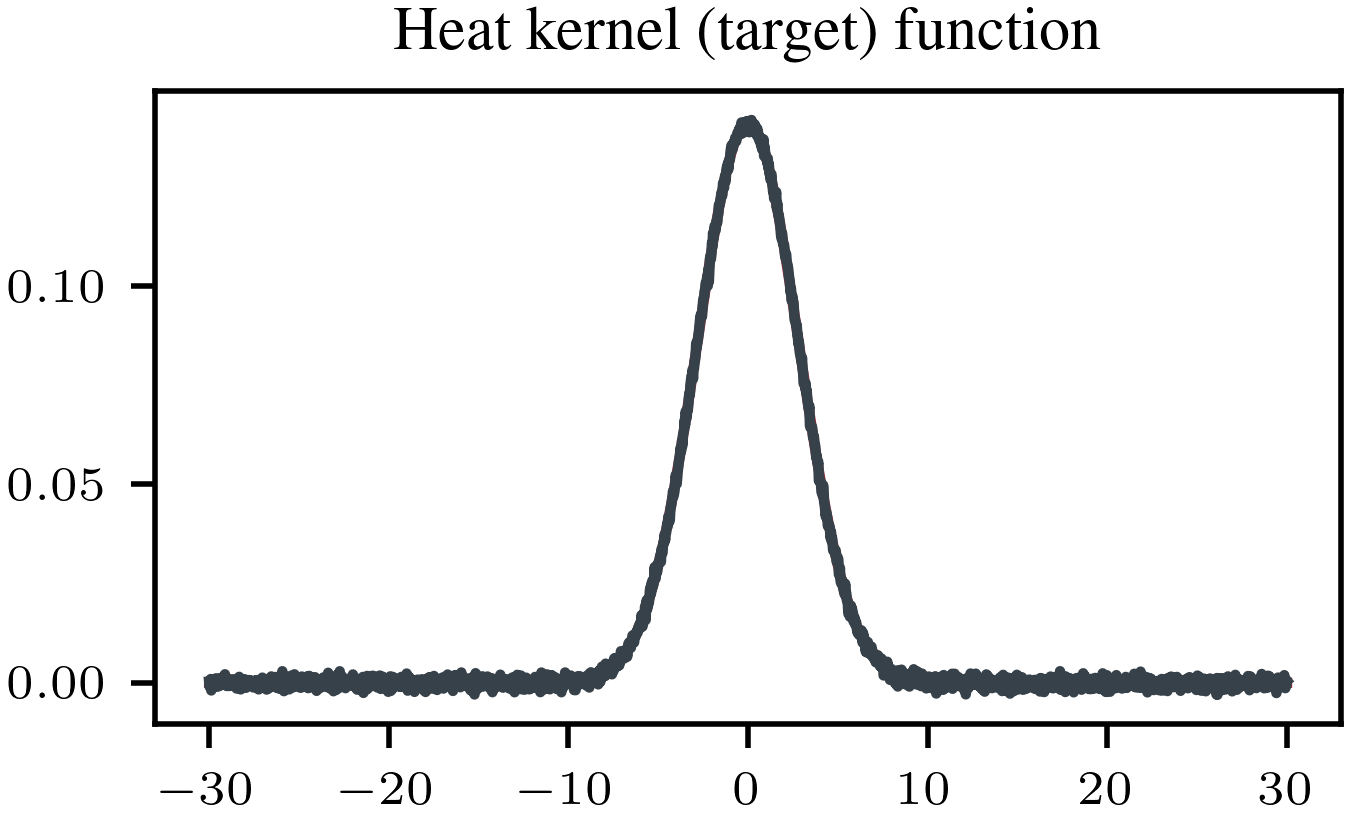

In [34]:
target = compute_heat_kernel(time_array, t_fix)
target_coeff = compute_fourier_coeff(target, time_span)
#plot the target function
plt.plot(time_array, target, label='Target function')
plt.plot(time_array, target + noise * rng.normal(size=grid_size), label='Noisy target function')
plt.title('Heat kernel (target) function')

In [35]:
#Choose a kernel 

kernel_decay =  2 # decay rate of the  complex exponential kernel   
b = 1.5 # scale of the complex exponential kernel
kernel_coeff = get_fourier_coeffs(kernel_decay, time_span, grid_size, c0=(b-1)/(b+1), scale=(b-1)/(b+1))

# from kernels import dirichlet_kernel
# kernel= dirichlet_kernel(time_array, 1)
# kernel_coeff = compute_fourier_coeff(kernel, time_span)


# or other kernel??

In [36]:
# Input functions 
delta_small = .5
delta_big = 5
samples_delta_small = generate_time_localized_samples(num_samples, time_array, delta_small, shift_center=0., std=1.96,rng=rng) 
samples_delta_big = generate_time_localized_samples(num_samples, time_array, delta_big, shift_center=0., std=1.96,rng=rng)

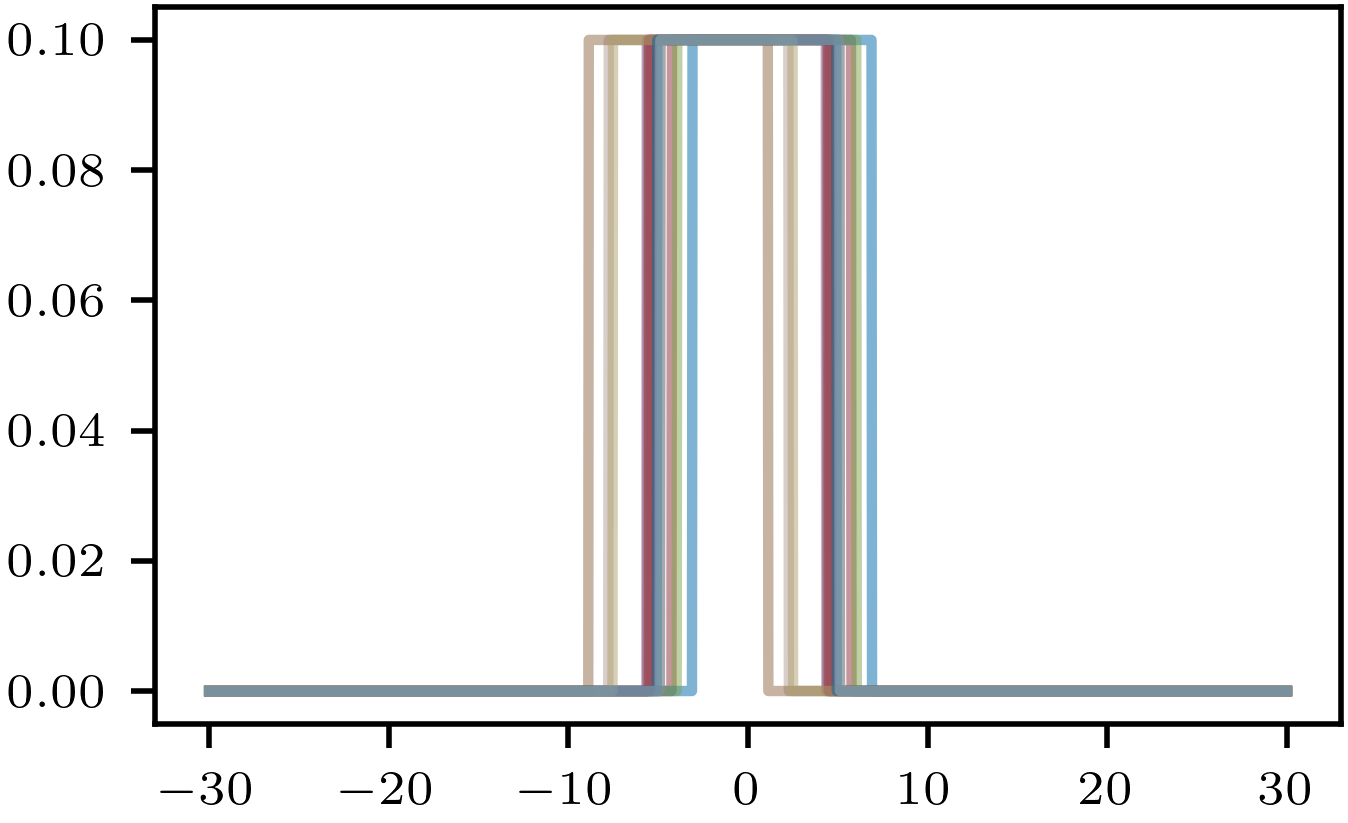

In [37]:
plt.plot(time_array, samples_delta_big, alpha=0.5, label='Input functions');

In [38]:
# run inference for time-localized signals, for both values of delta 
_, heat_kernel_prediction_delta_small = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    X= samples_delta_small,
    lamb=None,
    optimize_lambda=True
)

_, heat_kernel_prediction_delta_big = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    X= samples_delta_big,
    lamb=None,
    optimize_lambda=True
)

Computed sigma_max = 7.194e+02+0.000e+00j
Lambda candidates range: from 7.194e-03+0.000e+00j to 7.194e+01+0.000e+00j
Initial error with lambda = 7.194e-03+0.000e+00j: 6.262e-03+0.000e+00j
Best lambda: 7.194e-03+0.000e+00j with error: 6.262e-03+0.000e+00j
Computed sigma_max = 6.559e+02+0.000e+00j
Lambda candidates range: from 6.559e-03+0.000e+00j to 6.559e+01+0.000e+00j
Initial error with lambda = 6.559e-03+0.000e+00j: 9.381e-03+0.000e+00j
Best lambda: 6.559e-03+0.000e+00j with error: 9.280e-03+0.000e+00j


### Plotting


In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

from tueplots import  bundles, cycler
from tueplots.constants.color import palettes
from tueplots import figsizes, fontsizes

plt.rcParams.update({"figure.dpi": 250})
plt.rcParams.update(bundles.neurips2023(rel_width=.5))
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))

#define colors
dark = np.array([51.0, 51.0, 51.0]) / 255.0
gold = np.array([174.0, 159.0, 109.0]) / 255.0

my_blue= np.array([117,107,177]) / 255.0
my_orange = np.array([217,95,2]) / 300.0



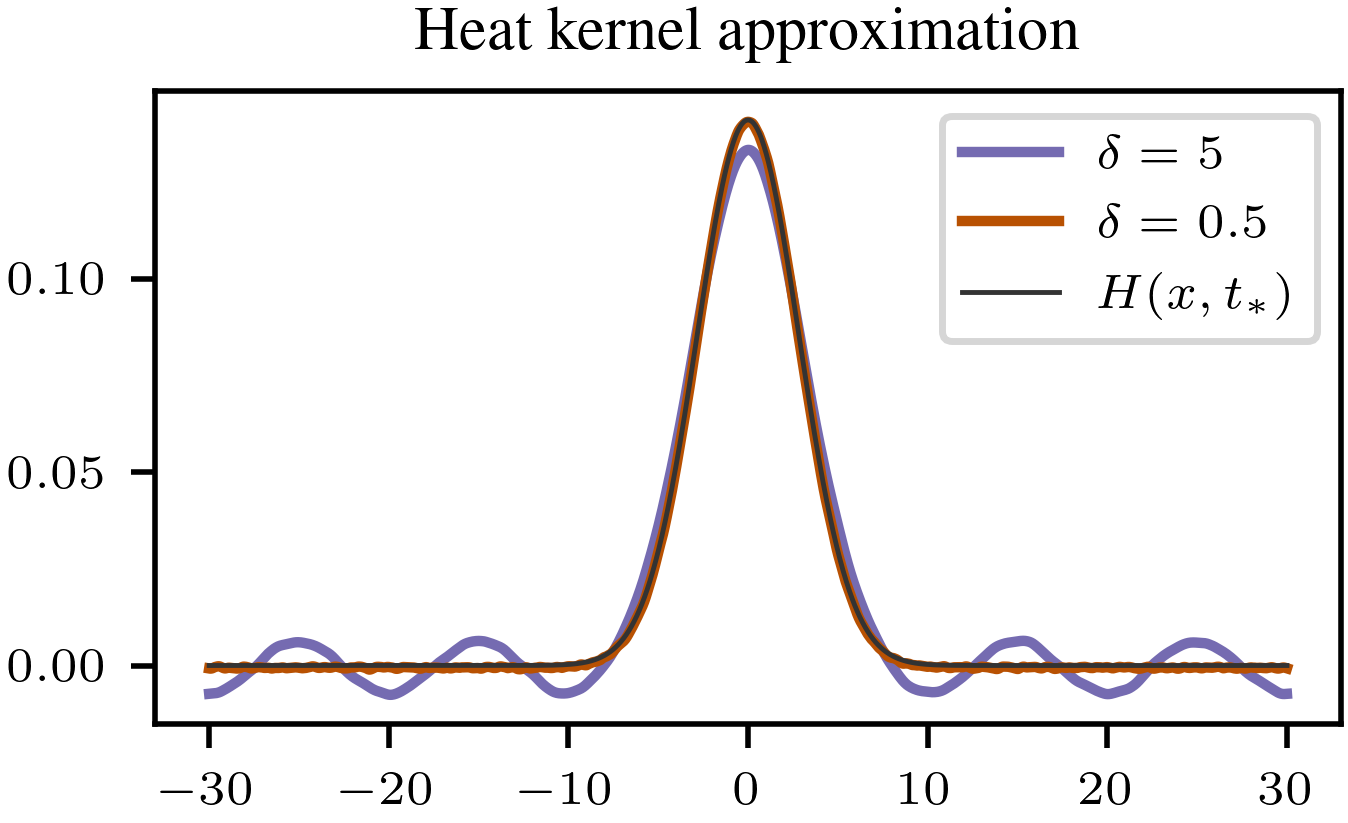

In [40]:
fig, ax = plt.subplots(1, )
ax.plot(time_array, heat_kernel_prediction_delta_big, color = my_blue, label='$\delta=5$')
ax.plot(time_array, heat_kernel_prediction_delta_small,  color = my_orange, label='$\delta=0.5$')
ax.plot(time_array, target,  color = dark, linewidth =.7, label='$H(x,t_*)$')
ax.set_title('Heat kernel approximation')
ax.legend()
# plt.savefig('../results/heat_kernel_approximation.pdf', bbox_inches='tight')

Text(0, 0.5, '$y$')

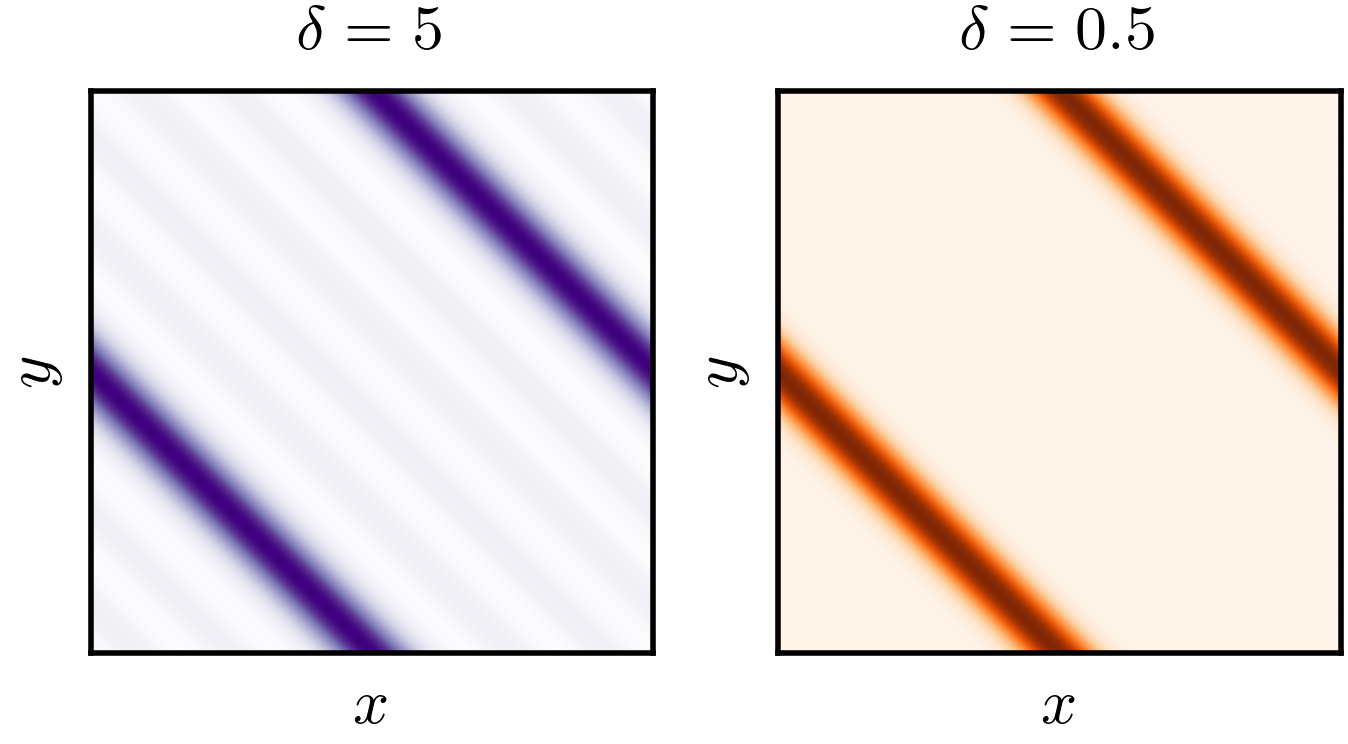

In [41]:
# two subplots, one with the convolution matrx of the prediction and one with its circulant matrix
from convolution_matrices import toeplix_matrix, circulant_convolution_matrix
fig, ax = plt.subplots(1, 2)
ax[1].imshow(circulant_convolution_matrix(heat_kernel_prediction_delta_small), cmap ='Oranges', origin='upper')
ax[1].set_title('$\delta=0.5$')
ax[0].imshow(circulant_convolution_matrix(heat_kernel_prediction_delta_big), cmap ='Purples', origin='upper')
ax[0].set_title('$\delta=5$')
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$y$')
# plt.savefig('../results/convolution_matrices.pdf', bbox_inches='tight')


Text(0, 0.5, '$y$')

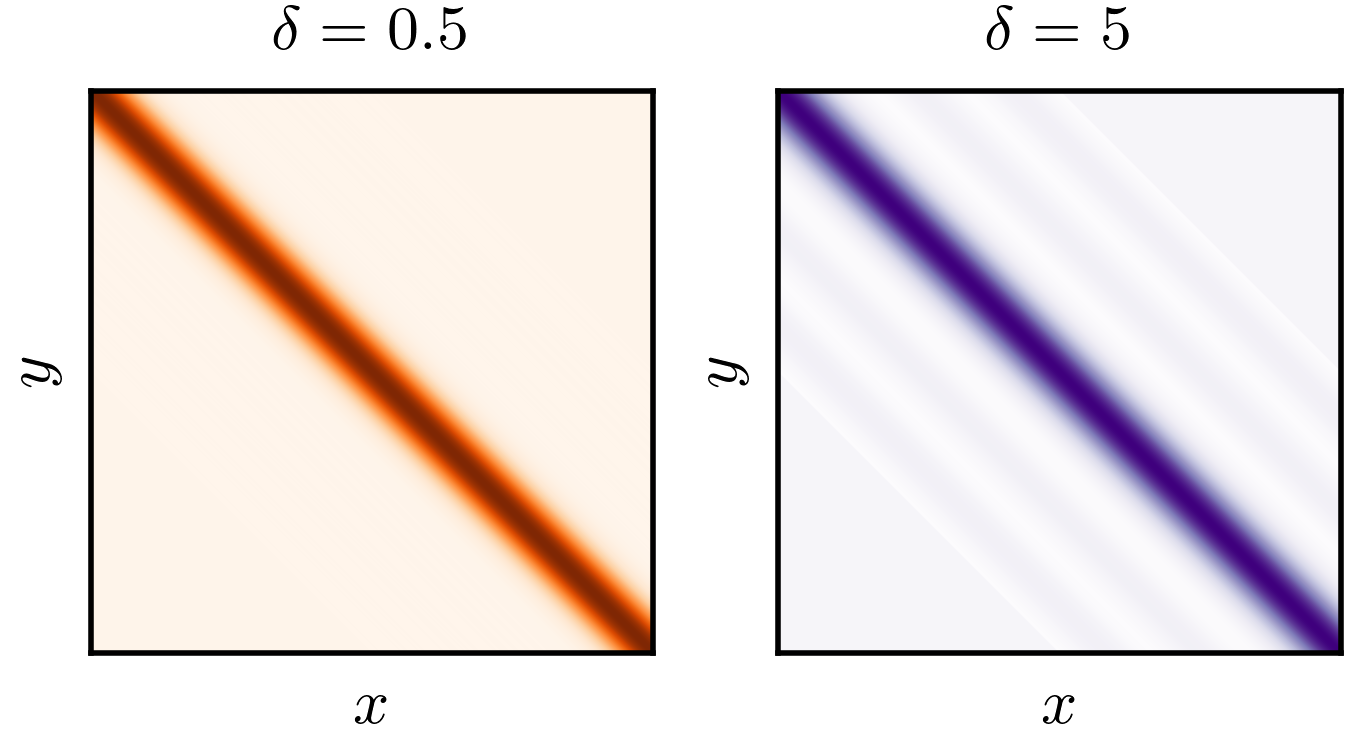

In [42]:

fig, ax = plt.subplots(1, 2)
ax[0].imshow(toeplix_matrix(heat_kernel_prediction_delta_small), cmap ='Oranges', origin='upper')
ax[0].set_title('$\delta=0.5$')
ax[1].imshow(toeplix_matrix(heat_kernel_prediction_delta_big), cmap ='Purples', origin='upper')
ax[1].set_title('$\delta=5$')
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$y$')

